<a href="https://colab.research.google.com/github/SLIIT-24-25J-047-Research/INTERVIEW-PROCESSING-SYSTEM/blob/IT21170966-Indudini_Thennakon/StressDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [5]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')

In [6]:
data.shape

(35887, 3)

In [7]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
data.Usage.value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [9]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


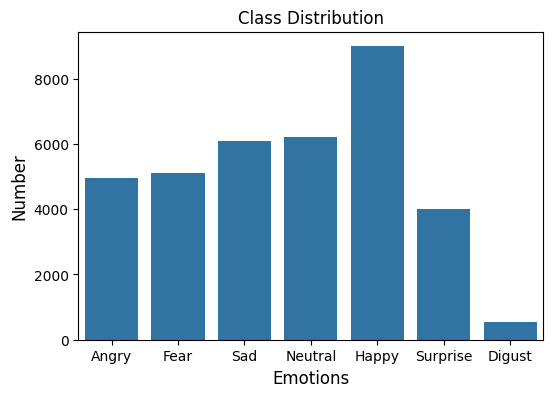

In [10]:
plt.figure(figsize=(6, 4))
sns.barplot(x='emotion', y='number', data=emotion_counts)
plt.title('Class Distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()



In [11]:
def row2image(row):
    # Ensure 'pixels' is processed into a NumPy array
    if isinstance(row['pixels'], str):
        img = np.fromstring(row['pixels'], sep=' ')
    else:
        img = np.array(row['pixels'])

    emotion = row['emotion']

    # Reshape the array and handle errors
    if img.size != 48 * 48:
        raise ValueError(f"Unexpected image size: {img.size}. Expected 2304 (48x48).")

    img = np.reshape(img, (48, 48))  # Reshape to 48x48
    image = np.zeros((48, 48, 3))  # Create an RGB image
    image[:, :, 0] = img
    image[:, :, 1] = img
    image[:, :, 2] = img
    return image.astype(np.uint8), emotion


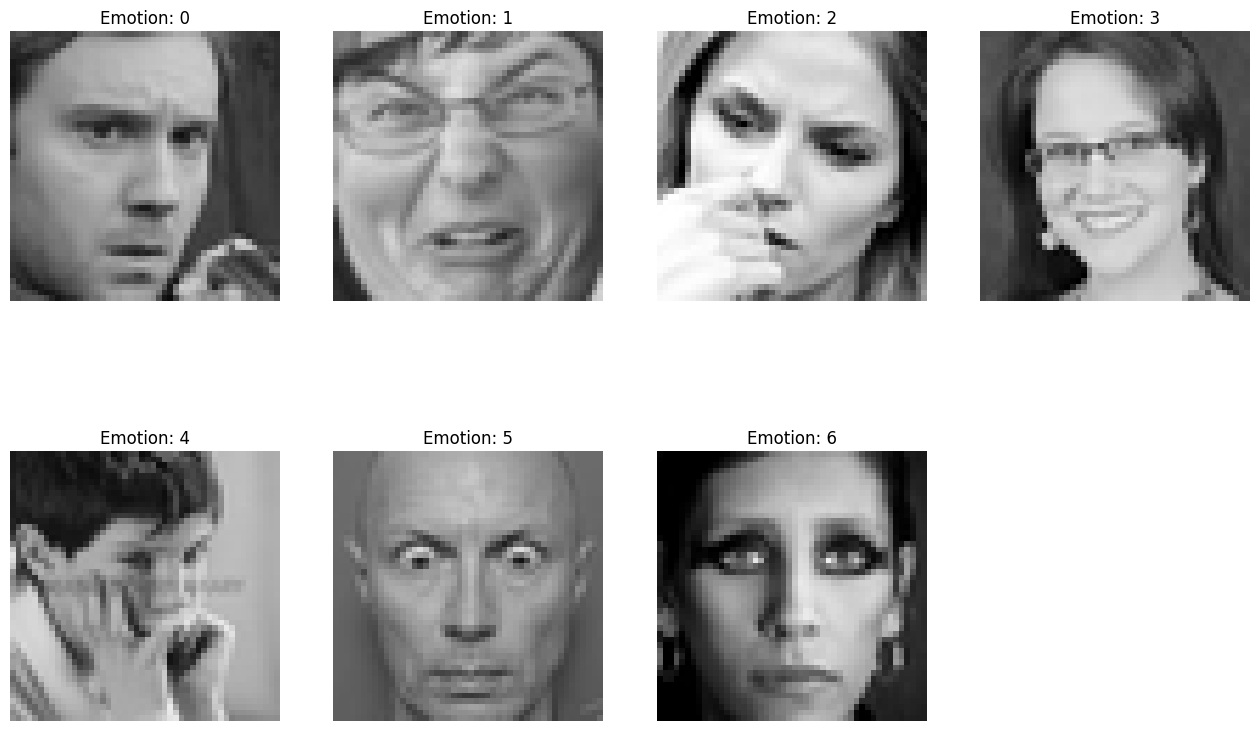

In [12]:
plt.figure(0, figsize=(16, 10))
for i in range(1, 8):
    try:
        face = data[data['emotion'] == i - 1].iloc[0]  # Select a row for each emotion
        img, emotion = row2image(face)  # Unpack the tuple
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.title(f'Emotion: {emotion}')
        plt.axis('off')
    except ValueError as e:
        print(f"Error processing row for emotion {i - 1}: {e}")
plt.show()


In [13]:


#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
#data_train = data_train[data_train['emotion']!=1]
#data_val = data_val[data_val['emotion']!=1]
##data_test = data_test[data_test['emotion']!=1]
#data_train['emotion'] = data_train['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_test['emotion'] = data_test['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_val['emotion'] = data_val['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))



train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


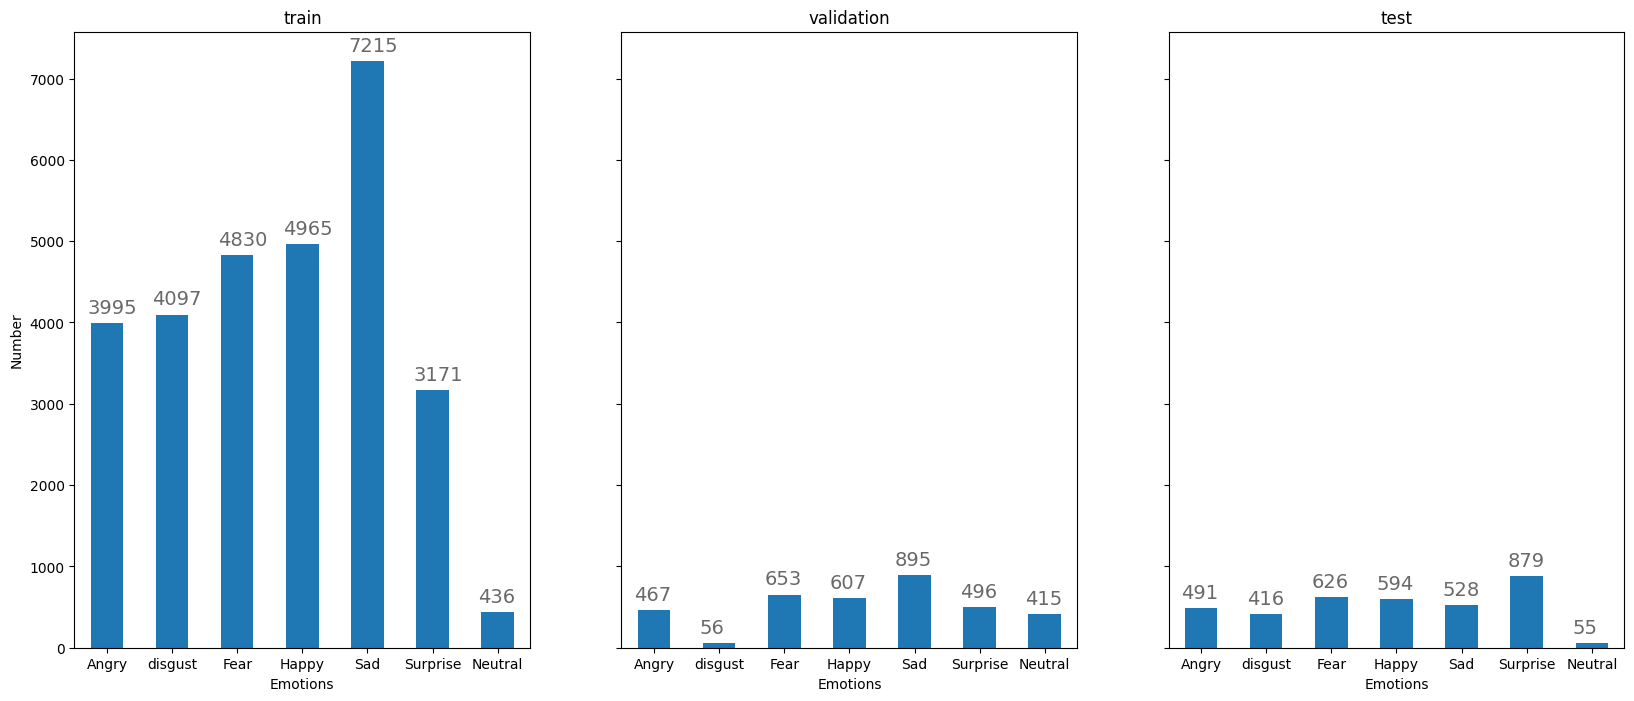

In [14]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)


fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [15]:


#initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64



In [16]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data



train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [17]:
import os
import cv2

data_path = '/content/drive/MyDrive/CK+48'
data_dir_list = os.listdir(data_path)

img_data_list=[]

numbers = []
c=0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        input_img_resize = np.reshape(input_img_resize,(48,48,1))
        img_data_list.append(input_img_resize)
        c += 1
    numbers.append(c)
    c = 0

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-sadness

Loaded the images of dataset-happy

Loaded the images of dataset-fear

Loaded the images of dataset-surprise

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-anger



(497, 48, 48, 1)

In [18]:
pl = img_data
np.reshape(pl[0],(48,48,1))
pl[0].shape



(48, 48, 1)

In [19]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=6 #54
labels[189:365]=1 #177
labels[366:440]=2 #75
labels[441:647]=3 #207
labels[648:731]=4 #84
labels[732:980]=5 #249

names = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def getLabel(id):
    return ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][id]



In [20]:
from keras.utils import to_categorical  # Correct import
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Convert labels to one-hot encoding
Y = to_categorical(labels, num_classes)  # Use to_categorical directly

# Shuffle the dataset
x, y = shuffle(img_data, Y, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)


In [21]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():

    inputs = Input(shape=(48, 48, 1))
    num_filters = 32

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2,3, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)

    model = Model(inputs, t)

    return model

#output layer
#model.add(Dense(6,activation='softmax'))

In [22]:
pip install stn

In [23]:
from tensorflow import keras
from keras import layers
from keras.layers import Layer
from stn import spatial_transformer_network as transformer

# Define the custom Spatial Transformer Layer
class SpatialTransformer(Layer):
    def __init__(self):
        super(SpatialTransformer, self).__init__()

    def call(self, inputs):
        feat_map, theta = inputs
        return transformer(feat_map, theta)

# Input layer
img_inputs = keras.Input(shape=(48, 48, 1))

# Localization network
locnet = layers.Conv2D(32, 3, padding='same')(img_inputs)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(64, 3, padding='same')(locnet)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(96, 3, padding='same')(locnet)
feat_map = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Flatten()(feat_map)
locnet = layers.Dense(90, activation='relu', kernel_regularizer='l2')(locnet)
locnet = layers.Dropout(0.2)(locnet)
locnet = layers.Dense(32, activation='relu', kernel_regularizer='l2')(locnet)
theta = layers.Dense(6, activation='linear')(locnet)

# Localization network model
locnet = keras.Model(img_inputs, theta, name="locnet")

# Spatial Transformer Network
outstn = SpatialTransformer()([feat_map, theta])

# Feature extraction network
fe = layers.Conv2D(32, 3, padding='same')(img_inputs)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3, padding='same')(fe)
fe = layers.Conv2D(64, 3, padding='same')(fe)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3, padding='same')(fe)
fe = layers.Conv2D(96, 3, padding='same')(fe)
fe = layers.Activation('relu')(fe)
do = layers.BatchNormalization()(fe)

fe = keras.Model(img_inputs, do, name="feature extractor")

# Combine outputs
add = layers.Add()([outstn, do])

# Flatten and dense layers
flats = layers.Flatten()(add)
flats = layers.Dense(64, activation='relu', kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
flats = layers.Dense(32, activation='relu', kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)

# Multiple dense outputs averaged
x1 = layers.Dense(7, activation='linear')(flats)
x2 = layers.Dense(7, activation='linear')(flats)
x3 = layers.Dense(7, activation='linear')(flats)
x4 = layers.Dense(7, activation='linear')(flats)
avg = layers.Average()([x1, x2, x3, x4])

# Final output layer
out = layers.Dense(7, activation='softmax')(avg)

# Final model
model = keras.Model(inputs=img_inputs, outputs=out, name="FEMSTN")

# Learning rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "FEMSTN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 48, 48, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 16, 16, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 32)     │            128 │ activation[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 6, 6, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 48, 48, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 6, 6, 64)       │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 48, 48, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 6, 6, 64)       │            256 │ activation_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 48, 48, 32)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 6, 6, 96)       │         55,392 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 6, 6, 96)       │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)    

 Total params: 688,116 (2.62 MB)

 Trainable params: 687,540 (2.62 MB)

 Non-trainable params: 576 (2.25 KB)

In [24]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)



In [25]:
from keras.layers import LeakyReLU

model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(48, 48, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 2
model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 3
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))


#dense 4
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=100,
    decay_rate=0.5,
    staircase=False)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 46, 46, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 46, 46, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 46, 46, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 46, 46, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 46, 46, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 46, 46, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 23, 23, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 23, 23, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 23, 23, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 23, 23, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 11, 11, 128)         │             5

 Total params: 3,075,335 (11.73 MB)

 Trainable params: 3,072,007 (11.72 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [28]:
batch_size = 128
epochs = 3

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True
)

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Change file extensions to .keras
cp_path = './model_bacc.keras'  # Corrected extension
cpl_path = './model_fer_bloss.keras'  # Corrected extension
cp = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path, save_best_only=True, save_weights_only=False, verbose=0, monitor='val_accuracy')
cpl = tf.keras.callbacks.ModelCheckpoint(filepath=cpl_path, save_best_only=True, save_weights_only=False, verbose=2, monitor='val_loss')

# Training the model
history = model.fit(data_generator.flow(train_X, train_Y, 128),
                                epochs=3,
                                verbose=1,
                                callbacks=[cp, cpl, es],
                                validation_data=(val_X, val_Y))

Epoch 1/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.2381 - loss: 1.8899 
Epoch 1: val_loss improved from inf to 1.88434, saving model to ./model_fer_bloss.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 7822s 35s/step - accuracy: 0.2382 - loss: 1.8895 - val_accuracy: 0.1911 - val_loss: 1.8843
Epoch 2/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.3594 - loss: 1.6204 
Epoch 2: val_loss improved from 1.88434 to 1.81270, saving model to ./model_fer_bloss.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 7817s 35s/step - accuracy: 0.3595 - loss: 1.6202 - val_accuracy: 0.3182 - val_loss: 1.8127
Epoch 3/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.4456 - loss: 1.4283 
Epoch 3: val_loss improved from 1.81270 to 1.45579, saving model to ./model_fer_bloss.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 7803s 35s/step - accuracy: 0.4457 - loss: 1.4281 - val_accuracy: 0.4609 - val_loss: 1.4558


In [42]:
model.save('/content/drive/MyDrive/my_model.h5')

In [43]:
from keras import models

In [44]:
model = models.load_model('/content/drive/MyDrive/my_model.h5')

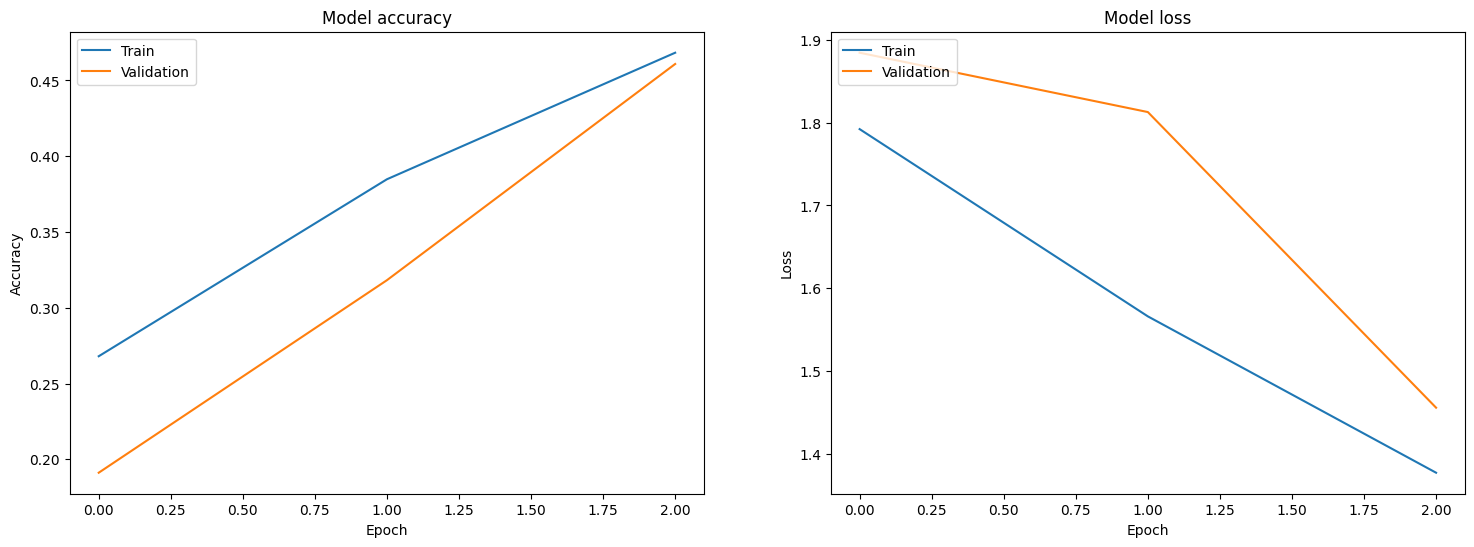

In [45]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [46]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))


113/113 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step
CNN Model Accuracy on test set: 0.4726
